In [1]:
import matplotlib.pyplot as plt
from omegaconf import OmegaConf
from paintmind.engine.util import instantiate_from_config
import torch

from paintmind.stage1.diffuse_slot import DiffuseSlot
from safetensors import safe_open

In [2]:
ckpt = {}
# with safe_open('/mnt/ceph_rbd/wx/work/slot_ar/output/'
#                'dit_ffhq256_2500ep_nest_after1500_32bs/models/step600000/model.safetensors',
# with safe_open('/mnt/ceph_rbd/zbc/slot_ar/output/imagenet820k.safetensors',
with safe_open('/mnt/ceph_rbd/zbc/slot_ar/output/dit_clevr4_ep400/models/step624800/model.safetensors',
               framework='pt', 
               device='cpu') as f:
    for key in f.keys():
        ckpt[key] = f.get_tensor(key)

In [3]:
ckpt.keys()

dict_keys(['dit.autoenc_cond_embedder.bias', 'dit.autoenc_cond_embedder.weight', 'dit.blocks.0.adaLN_modulation.1.bias', 'dit.blocks.0.adaLN_modulation.1.weight', 'dit.blocks.0.attn.proj.bias', 'dit.blocks.0.attn.proj.weight', 'dit.blocks.0.attn.qkv.bias', 'dit.blocks.0.attn.qkv.weight', 'dit.blocks.0.mlp.fc1.bias', 'dit.blocks.0.mlp.fc1.weight', 'dit.blocks.0.mlp.fc2.bias', 'dit.blocks.0.mlp.fc2.weight', 'dit.blocks.1.adaLN_modulation.1.bias', 'dit.blocks.1.adaLN_modulation.1.weight', 'dit.blocks.1.attn.proj.bias', 'dit.blocks.1.attn.proj.weight', 'dit.blocks.1.attn.qkv.bias', 'dit.blocks.1.attn.qkv.weight', 'dit.blocks.1.mlp.fc1.bias', 'dit.blocks.1.mlp.fc1.weight', 'dit.blocks.1.mlp.fc2.bias', 'dit.blocks.1.mlp.fc2.weight', 'dit.blocks.10.adaLN_modulation.1.bias', 'dit.blocks.10.adaLN_modulation.1.weight', 'dit.blocks.10.attn.proj.bias', 'dit.blocks.10.attn.proj.weight', 'dit.blocks.10.attn.qkv.bias', 'dit.blocks.10.attn.qkv.weight', 'dit.blocks.10.mlp.fc1.bias', 'dit.blocks.10.mlp.

In [4]:
keys = ['encoder2slot.bias', 'encoder2slot.weight', 'grouping.slot_embed.weight', 'nested_sampler.arange', 
'nested_sampler.attn.in_proj_bias', 'nested_sampler.attn.in_proj_weight', 'nested_sampler.attn.out_proj.bias', 
'nested_sampler.attn.out_proj.weight', 'nested_sampler.slot2attn.bias', 'nested_sampler.slot2attn.weight', 'sampler_latents',]

In [5]:
for key in keys:
    print(key, ckpt[key].shape)

encoder2slot.bias torch.Size([16])
encoder2slot.weight torch.Size([16, 768, 1, 1])
grouping.slot_embed.weight torch.Size([128, 16])
nested_sampler.arange torch.Size([128])
nested_sampler.attn.in_proj_bias torch.Size([48])
nested_sampler.attn.in_proj_weight torch.Size([48, 16])
nested_sampler.attn.out_proj.bias torch.Size([16])
nested_sampler.attn.out_proj.weight torch.Size([16, 16])
nested_sampler.slot2attn.bias torch.Size([16])
nested_sampler.slot2attn.weight torch.Size([16, 16])
sampler_latents torch.Size([128, 16])


In [6]:
num_samplers = 128
sampler_dim = 16
num_slots = 128
slot_dim = 16

In [7]:
# cfg = OmegaConf.load('/mnt/ceph_rbd/zbc/slot_ar/configs/ffhq256_1264.yaml')
cfg = OmegaConf.load('/mnt/ceph_rbd/zbc/slot_ar/configs/dit_clevr4.yaml')

In [8]:
from paintmind.data.coco import vae_transforms
from PIL import Image

transform = vae_transforms('test')


def norm_ip(img, low, high):
    img.clamp_(min=low, max=high)
    img.sub_(low).div_(max(high - low, 1e-5))

def norm_range(t, value_range):
    if value_range is not None:
        norm_ip(t, value_range[0], value_range[1])
    else:
        norm_ip(t, float(t.min()), float(t.max()))

from PIL import Image
def convert_np(img):
    ndarr = img.mul(255).add_(0.5).clamp_(0, 255)\
            .permute(1, 2, 0).to("cpu", torch.uint8).numpy()
    return ndarr
def convert_PIL(img):
    ndarr = img.mul(255).add_(0.5).clamp_(0, 255)\
            .permute(1, 2, 0).to("cpu", torch.uint8).numpy()
    img = Image.fromarray(ndarr)
    return img


In [9]:
model = DiffuseSlot(**cfg['trainer']['params']['model']['params'])
model.load_state_dict(ckpt, strict=False)
model.cuda()

/mnt/ceph_rbd/zbc/slot_ar/paintmind/stage1/diffuse_slot.py:346: FutureWarning: Accessing config attribute `scaling_factor` directly via 'AutoencoderKL' object attribute is deprecated. Please access 'scaling_factor' over 'AutoencoderKL's config object instead, e.g. 'unet.config.scaling_factor'.
  self.scaling_factor = self.vae.scaling_factor
/mnt/ceph_rbd/zbc/slot_ar/paintmind/stage1/dinov2_layers/swiglu_ffn.py:51: UserWarning: xFormers is not available (SwiGLU)
  warnings.warn("xFormers is not available (SwiGLU)")
/mnt/ceph_rbd/zbc/slot_ar/paintmind/stage1/dinov2_layers/attention.py:33: UserWarning: xFormers is not available (Attention)
  warnings.warn("xFormers is not available (Attention)")
/mnt/ceph_rbd/zbc/slot_ar/paintmind/stage1/dinov2_layers/block.py:40: UserWarning: xFormers is not available (Block)
  warnings.warn("xFormers is not available (Block)")


DiffuseSlot(
  (dit): DiT_with_autoenc_cond(
    (x_embedder): PatchEmbed(
      (proj): Conv2d(4, 1152, kernel_size=(2, 2), stride=(2, 2))
      (norm): Identity()
    )
    (t_embedder): TimestepEmbedder(
      (mlp): Sequential(
        (0): Linear(in_features=256, out_features=1152, bias=True)
        (1): SiLU()
        (2): Linear(in_features=1152, out_features=1152, bias=True)
      )
    )
    (y_embedder): LabelEmbedder(
      (embedding_table): Embedding(1001, 1152)
    )
    (blocks): ModuleList(
      (0-27): 28 x DiTBlock(
        (norm1): LayerNorm((1152,), eps=1e-06, elementwise_affine=False)
        (attn): Attention(
          (qkv): Linear(in_features=1152, out_features=3456, bias=True)
          (attn_drop): Dropout(p=0.0, inplace=False)
          (proj): Linear(in_features=1152, out_features=1152, bias=True)
          (proj_drop): Dropout(p=0.0, inplace=False)
        )
        (norm2): LayerNorm((1152,), eps=1e-06, elementwise_affine=False)
        (mlp): Mlp(
    

In [10]:
img = Image.open('/mnt/ceph_rbd/zbc/ffhq-dataset/images256x256/00000.png')

In [11]:
img, _ = transform(img, None)
img = img.cuda().unsqueeze(0)

In [12]:
output = model(img.to('cuda'), None, sample=True)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [13]:
output.shape

torch.Size([1, 3, 256, 256])

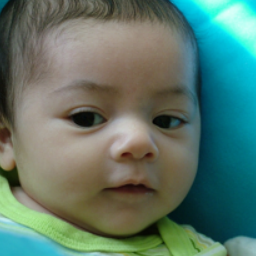

In [14]:
img = convert_PIL(img[0])
img

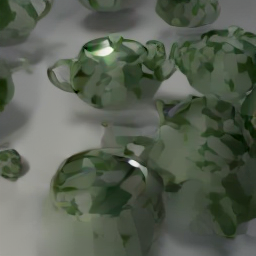

In [15]:
convert_PIL(output[0])

In [10]:
img1 = Image.open('/mnt/ceph_rbd/zbc/ffhq-dataset/images256x256/00000.png')
img2 = Image.open('/mnt/ceph_rbd/zbc/ffhq-dataset/images256x256/00001.png')
# img1 = Image.open("/mnt/ceph_rbd/zbc/data/clevr-4/images/CLEVR_new_118650.png").convert("RGB")
# img2 = Image.open("/mnt/ceph_rbd/zbc/data/clevr-4/images/CLEVR_new_038680.png").convert("RGB")

img1, _ = transform(img1, None)
img2, _ = transform(img2, None)

img1 = img1.cuda().unsqueeze(0)
img2 = img2.cuda().unsqueeze(0)

In [11]:
slots1, _ = model.encode_slots(img1)
slots2, _ = model.encode_slots(img2)

In [12]:
model.diffusion.

SyntaxError: invalid syntax (2826601050.py, line 1)

In [13]:
recon1 = model.sample_from_slots(slots1, slots1.device, ddim=True)
recon2 = model.sample_from_slots(slots2, slots2.device, ddim=True)

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

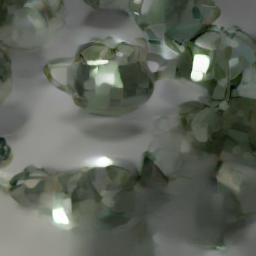

In [14]:
convert_PIL(recon1[0])

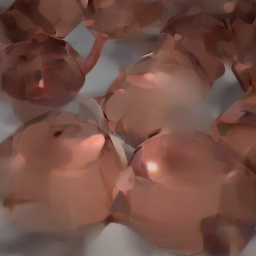

In [15]:
convert_PIL(recon2[0])

### Grafting

In [21]:
slots1.shape

torch.Size([1, 128, 16])

In [22]:
img2_token_num = 40
grafted_slots = slots1.clone()
grafted_slots[:, img2_token_num:] = slots2[:, img2_token_num:]

In [23]:
grafted_slots.shape

torch.Size([1, 128, 16])

In [24]:
batch_slots = []
for num_grafted_img2 in range(8, 64, 8):
    grafted_slots = slots1.clone()
    grafted_slots[:, num_grafted_img2:] = slots2[:, num_grafted_img2:]
    batch_slots.append(grafted_slots)
batch_slots = torch.cat(batch_slots, dim=0)

grafted_recon = model.sample_from_slots(batch_slots, batch_slots.device)

  0%|          | 0/1000 [00:00<?, ?it/s]

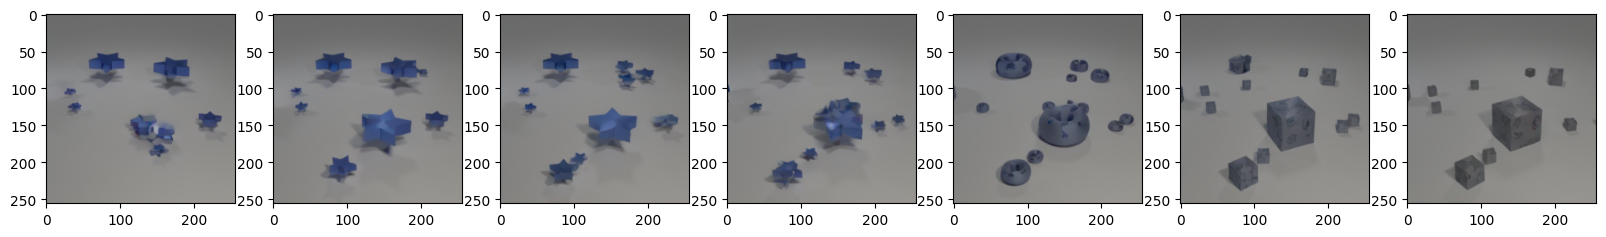

In [29]:
plt.figure(figsize=(20, 5))
for i in range(len(batch_slots)):
    plt.subplot(1, len(batch_slots), i+1)
    plt.imshow(convert_np(grafted_recon[i]))
plt.show()

#### Grafting with VAE

In [14]:
vae1 = model.vae_encode(img1).reshape(1, 4, -1)
vae2 = model.vae_encode(img2).reshape(1, 4, -1)

In [21]:
grafted_vae = []
for num_grafted_img2 in range(8, 32*32, 32*4):
    grafted_vae.append(torch.cat([vae1[:, :, :num_grafted_img2], vae2[:, :, num_grafted_img2:]], dim=-1))
grafted_vae = torch.cat(grafted_vae, dim=0)

In [22]:
grafted_vae = grafted_vae.reshape(-1, 4, 32, 32)

In [23]:
grafted_vae_recon = model.vae_decode(grafted_vae)

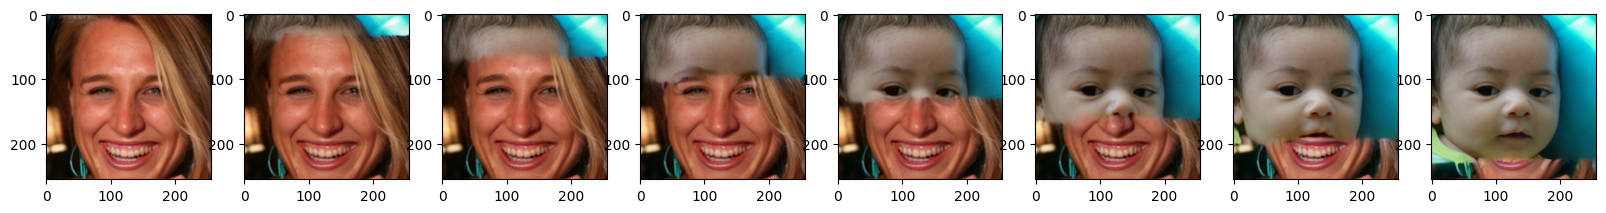

In [25]:
plt.figure(figsize=(20, 5))
for i in range(len(grafted_vae_recon)):
    plt.subplot(1, len(grafted_vae_recon), i+1)
    plt.imshow(convert_np(grafted_vae_recon[i]))
plt.show()

In [24]:
grafted_vae_recon.shape

torch.Size([8, 3, 256, 256])

### Inference with n slots

In [26]:
model.training

True

In [27]:
model.eval();

In [28]:
n_slots_inf = []
for num_slots_to_inference in range(8, 64, 8):
    recon_n = model.sample_from_slots(
        slots1, slots1.device, inference_with_n_slots=num_slots_to_inference
    )
    n_slots_inf.append(recon_n)
for i in range(len(n_slots_inf)):
    plt.imshow(convert_np(n_slots_inf[i][0]))
    plt.show()

  0%|          | 0/1000 [00:00<?, ?it/s]

KeyboardInterrupt: 

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

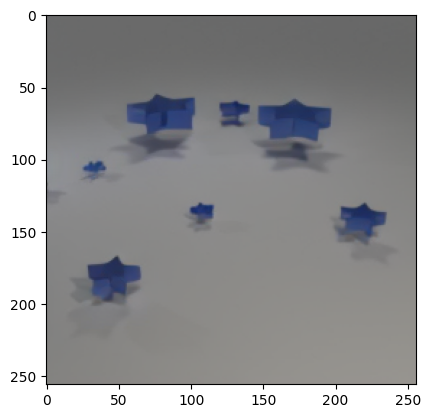

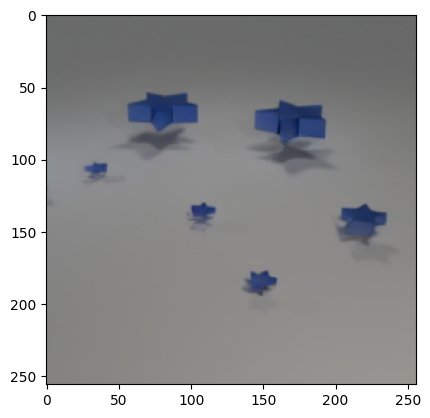

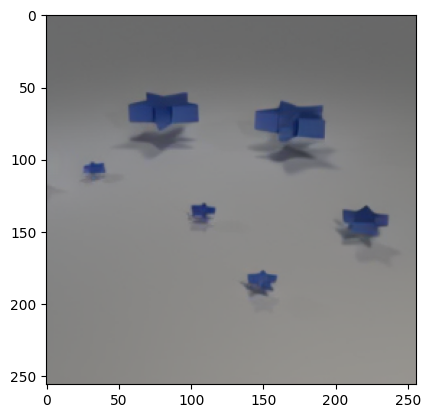

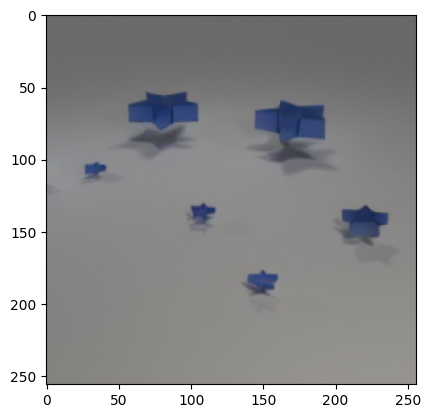

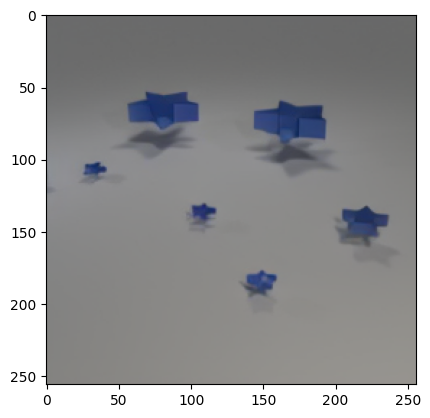

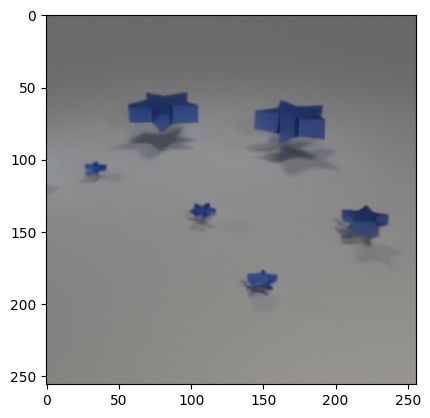

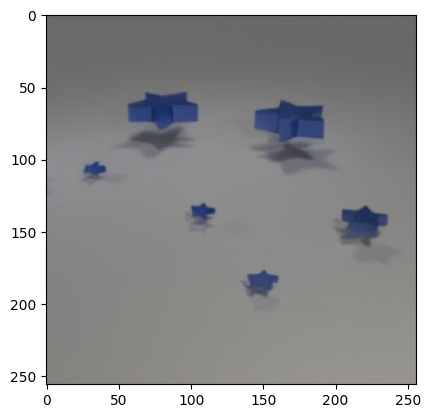

In [ ]:
n_slots_inf = []
for num_slots_to_inference in range(8, 64, 8):
    recon_n = model.sample_from_slots(
        slots2, slots2.device, inference_with_n_slots=num_slots_to_inference
    )
    n_slots_inf.append(recon_n)
for i in range(len(n_slots_inf)):
    plt.imshow(convert_np(n_slots_inf[i][0]))
    plt.show()